In [5]:
import gc
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt

In [6]:
gc.collect()
torch.cuda.empty_cache()

In [7]:
def load_cifar10_dataset(train_batch_size, val_batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
    trainset, valset = torch.utils.data.random_split(trainset, [len(trainset) - 5000, 5000])
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size,shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=val_batch_size,shuffle=False, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=val_batch_size,shuffle=False, num_workers=2)
    return trainloader, valloader, testloader

In [8]:
train_batch_size = 128
val_batch_size = 128
trainloader, valloader, testloader = load_cifar10_dataset(train_batch_size, val_batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, 2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, 2)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, 2)
        )

        self.conv = nn.Sequential(
            self.layer1,
            self.layer2,
            self.layer3,
            self.layer4,
            self.layer5
        )

        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 512)
        x = self.fc(x)
        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net=Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [11]:
train_=[]
val_=[]
def train(net, trainloader, valloader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):            
            inputs, labels = data
            inputs, labels = inputs.to(device),labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)

        net.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted.to(device) == labels.to(device)).sum().item()

        val_loss /= len(valloader)
        val_losses.append(val_loss)

        print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Val Accuracy: {:.2f}%'
              .format(epoch+1, num_epochs, train_loss, val_loss, 100 * correct / total))
        train_.append(train_loss)
        val_.append(val_loss)
    return train_losses, val_losses

In [12]:
num_epochs = 20
train_losses, val_losses = train(net, trainloader, valloader, criterion, optimizer, num_epochs)

Epoch [1/20], Train Loss: 1.5102, Val Loss: 1.3865, Val Accuracy: 50.76%
Epoch [2/20], Train Loss: 0.9572, Val Loss: 0.8926, Val Accuracy: 70.10%
Epoch [3/20], Train Loss: 0.7344, Val Loss: 0.8460, Val Accuracy: 72.56%
Epoch [4/20], Train Loss: 0.5850, Val Loss: 0.7110, Val Accuracy: 76.34%
Epoch [5/20], Train Loss: 0.4860, Val Loss: 0.6738, Val Accuracy: 78.60%
Epoch [6/20], Train Loss: 0.3947, Val Loss: 0.5936, Val Accuracy: 80.56%
Epoch [7/20], Train Loss: 0.3258, Val Loss: 0.5732, Val Accuracy: 82.64%
Epoch [8/20], Train Loss: 0.2795, Val Loss: 0.6448, Val Accuracy: 81.12%
Epoch [9/20], Train Loss: 0.2189, Val Loss: 0.7207, Val Accuracy: 80.46%
Epoch [10/20], Train Loss: 0.1813, Val Loss: 0.6449, Val Accuracy: 82.26%
Epoch [11/20], Train Loss: 0.1526, Val Loss: 0.7439, Val Accuracy: 81.38%
Epoch [12/20], Train Loss: 0.1214, Val Loss: 0.6133, Val Accuracy: 83.68%
Epoch [13/20], Train Loss: 0.0998, Val Loss: 0.7354, Val Accuracy: 82.26%
Epoch [14/20], Train Loss: 0.0899, Val Loss: 0.

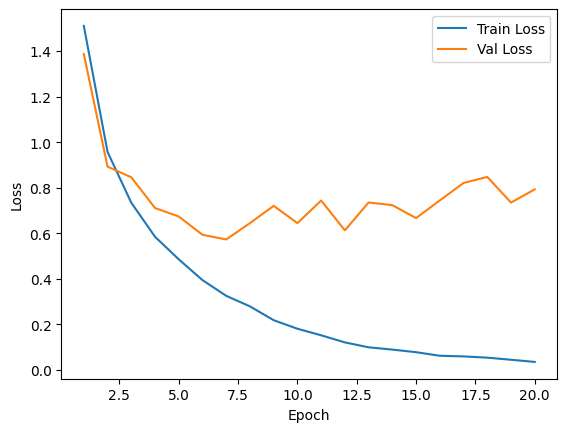

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(1, 21), train_losses, label='Train Loss')
plt.plot(range(1, 21), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('plot.png')
plt.legend()
plt.show()